In [153]:
! pip install sqlalchemy pyodbc

In [ ]:
# Import Libraries
import sqlalchemy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import IsolationForest
import seaborn as sns
import pickle


In [155]:
# Establish Connection
server = r"SAKS\SQLEXPRESS"
database = "HEALTHCARE_"
username = "Saks"
password = "Sql@2025"

In [156]:
# Creating SQLAlchemy engine using PyODBC
engine = sqlalchemy.create_engine(f"mssql+pyodbc://{server}/{database}?driver=SQL+Server&trusted_connection=yes") 

In [157]:
# Fetching all table names 
query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'"
df_tables = pd.read_sql(query, engine)

print(f"All Tables are Fetched \n\n {df_tables}")

# display all the column
pd.set_option('display.max_columns', None)

All Tables are Fetched 

                             TABLE_NAME
0            Medicare_Charge_Inpatient
1           Medicare_Charge_Outpatient
2   Medicare_Provider_Charge_Inpatient
3  Medicare_Provider_Charge_Outpatient
4                 Patient_history_samp
5          Review_patient_history_samp
6               Review_transaction_coo
7                      Transaction_coo
8      DRGCodes_Global_proc_id_Mapping


In [158]:
# Fetching data from a specific table
table_name = "Medicare_Provider_Charge_Inpatient"  
Medicare_Provider_Charge_Inpatient = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Medicare_Provider_Charge_Outpatient"  
Medicare_Provider_Charge_Outpatient = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Patient_history_samp"  
Patient_history_samp = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Transaction_coo"  
Transaction_coo = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "DRGCodes_Global_proc_id_Mapping"  
Global_proc_id = pd.read_sql(f"SELECT * FROM {table_name}", engine)

# Data Cleaning

In [159]:
Medicare_Provider_Charge_Inpatient.isna().sum()

DRG_Definition                              0
Provider_Id                                 0
Provider_Name                               0
Provider_Street_Address                     0
Provider_City                               0
Provider_State                              0
Provider_Zip_Code                           0
Hospital_Referral_Region_HRR_Description    0
Total_Discharges                            0
Average_Covered_Charges                     0
Average_Total_Payments                      0
Average_Medicare_Payments                   0
dtype: int64

In [160]:
Medicare_Provider_Charge_Outpatient.isna().sum()

APC                                         0
Provider_Id                                 0
Provider_Name                               0
Provider_Street_Address                     0
Provider_City                               0
Provider_State                              0
Provider_Zip_Code                           0
Hospital_Referral_Region_HRR_Description    0
Outpatient_Services                         0
Average_Estimated_Submitted_Charges         0
Average_Total_Payments                      0
dtype: int64

In [161]:
Patient_history_samp.isna().sum()

id        0
age       0
gender    0
income    0
dtype: int64

In [162]:
Transaction_coo.isna().sum()

id                0
global_proc_id    0
count             0
dtype: int64

In [163]:
Global_proc_id.isna().sum()

S_No              0
global_proc_id    0
DRG_Codes         0
dtype: int64

In [ ]:
# Renaming the columns

Medicare_Provider_Charge_Inpatient.rename(columns={"DRG_Definition":"Procedure","Total_Discharges":"Total_Discharge","Average_Covered_Charges":"Avg_covered_charges"},inplace=True)

Medicare_Provider_Charge_Outpatient.rename(columns={"APC":"Procedure","Outpatient_Services":"Total_Discharge","Average_Estimated_Submitted_Charges":"Avg_covered_charges"},inplace=True)

In [187]:
# Selecting necessary coloums
Medicare_Provider_Charge_Inpatient = Medicare_Provider_Charge_Inpatient[['Procedure','Provider_Name','Total_Discharge','Avg_covered_charges','Average_Total_Payments']]

Medicare_Provider_Charge_Outpatient = Medicare_Provider_Charge_Outpatient[['Procedure','Provider_Name','Total_Discharge','Avg_covered_charges','Average_Total_Payments']]

In [188]:
Medicare_Provider_Charge_Outpatient.head(2)

,Procedure,Provider_Name,Total_Discharge,Avg_covered_charges,Average_Total_Payments
0,0012 - Level I Debridement & Destruction,EAST ALABAMA MEDICAL CENTER AND SNF,23,78.086960,21.910435
1,0012 - Level I Debridement & Destruction,CENTRAL PENINSULA GENERAL HOSPITAL,994,149.589752,36.623852


In [189]:
Medicare_Provider_Charge_Inpatient.head(2)

,Procedure,Provider_Name,Total_Discharge,Avg_covered_charges,Average_Total_Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SOUTHEAST ALABAMA MEDICAL CENTER,91,32963.078125,5777.241699
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,MARSHALL MEDICAL CENTER SOUTH,14,15131.857422,5787.571289


In [ ]:
# Joining both inpatient and outpatient tables
df = pd.concat([Medicare_Provider_Charge_Inpatient,Medicare_Provider_Charge_Outpatient])
df.head()

,Procedure,Provider_Name,Total_Discharge,Avg_covered_charges,Average_Total_Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SOUTHEAST ALABAMA MEDICAL CENTER,91,32963.078125,5777.241699
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,MARSHALL MEDICAL CENTER SOUTH,14,15131.857422,5787.571289
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ELIZA COFFEE MEMORIAL HOSPITAL,24,37560.375000,5434.958496
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ST VINCENT'S EAST,25,13998.280273,5417.560059
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SHELBY BAPTIST MEDICAL CENTER,18,31633.277344,5658.333496


In [191]:
df.to_csv("processed_data.csv", index=False)  

# Anomaly detection using Isolation Forest

 1.Feature selection

In [193]:
categorical_col = ['Procedure','Provider_Name']

encoders = OrdinalEncoder()
df[categorical_col] = encoders.fit_transform(df[categorical_col])

mappings = {col: dict(zip(df[col], encoders.categories_[i])) for i, col in enumerate(categorical_col)}

In [194]:
X = df
# Normalize data using Min-Max Scaling (optional, but improves performance)
from sklearn.preprocessing import MinMaxScaler

scaled = MinMaxScaler()
X_scaled = scaled.fit_transform(X)


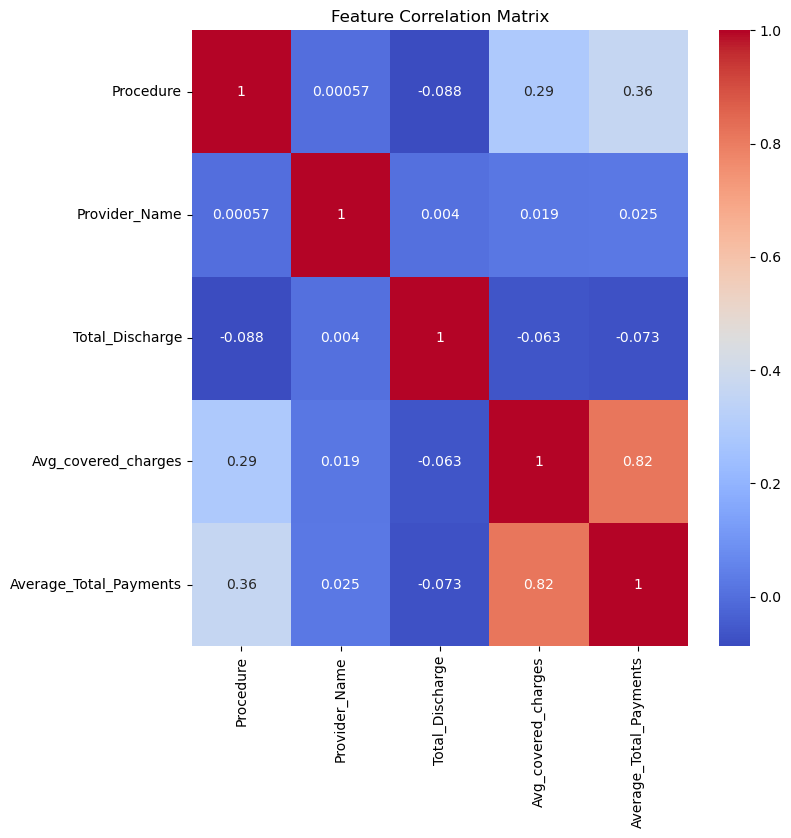

In [195]:
# Correlation Matrix
correlation_matrix = X.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

2. Isolation Forest model Training and Evaluation

In [ ]:
# Parameter selection for isolation forest
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150],
    'max_samples': ['auto', 0.8],
    'contamination': [0.01, 0.05],
    'random_state': [42]
}

iso_forest = IsolationForest()
grid_search = GridSearchCV(estimator=iso_forest, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X)

best_model = grid_search.best_estimator_
print(f"✅ Best Parameters: {grid_search.best_params_}")

c:\Users\LENOVO\anaconda3_new\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


✅ Best Parameters: {'contamination': 0.01, 'max_samples': 'auto', 'n_estimators': 100, 'random_state': 42}


In [ ]:
from sklearn.ensemble import IsolationForest

# Best Parameters from GridSearchCV applied
iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.01,
    random_state=42
)

#  Fit the model
iso_forest.fit(X)

# Predict anomalies (-1: anomaly, 1: normal)
predictions = iso_forest.predict(X)

#  Evaluate anomalies
anomaly_count = (predictions == -1).sum()
anomaly_ratio = anomaly_count / len(predictions)

print(f"✅ Anomalies Detected: {anomaly_count} out of {len(predictions)}")
print(f"⚡ Anomaly Ratio: {anomaly_ratio:.4f}")



✅ Anomalies Detected: 2065 out of 206437
⚡ Anomaly Ratio: 0.0100


3. Decision Function Score

✅ Decision Function Scores:
 [0.195   0.20689 0.18666 ... 0.15792 0.10075 0.11566]


c:\Users\LENOVO\anaconda3_new\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


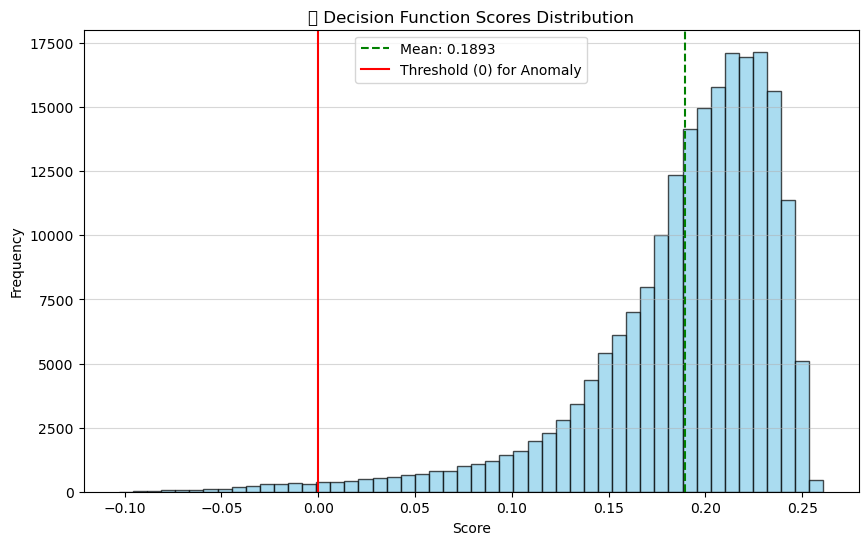

In [198]:
import matplotlib.pyplot as plt
import numpy as np

# ⚡ Get decision function scores
scores = best_model.decision_function(X)

# 📜 Print all score values
np.set_printoptions(precision=5, suppress=True)
print("✅ Decision Function Scores:\n", scores)

# 📊 Plot with mean and threshold (0) lines
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=np.mean(scores), color='green', linestyle='--', label=f'Mean: {np.mean(scores):.4f}')
plt.axvline(x=0, color='red', linestyle='-', label='Threshold (0) for Anomaly')
plt.title("✅ Decision Function Scores Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


In [199]:
df_ = df
df_['Anomaly_Score'] = iso_forest.fit_predict(X_scaled)

In [200]:
# Count anomalies
print(df_['Anomaly_Score'].value_counts())

# Extract only anomalous providers
anomalous_providers = df_[df_['Anomaly_Score'] == -1]
anomalous_providers[['Provider_Name', 'Avg_covered_charges', 'Average_Total_Payments', 'Total_Discharge']]


Anomaly_Score
 1    204372
-1      2065
Name: count, dtype: int64


,Provider_Name,Avg_covered_charges,Average_Total_Payments,Total_Discharge
15088,3061.0,212674.781250,26602.960938,50
15131,1887.0,212249.750000,34775.687500,16
15174,387.0,207757.859375,28742.960938,102
39447,157.0,189003.296875,34613.957031,24
39450,580.0,243678.453125,33423.453125,11
...,...,...,...,...
42648,3022.0,176.789047,33.726814,5434
42715,2692.0,166.266235,37.660938,7026
43201,2963.0,107.254593,74.691483,7336
43253,2973.0,189.348007,67.014046,5793


Anomalies Provider Distribution rate

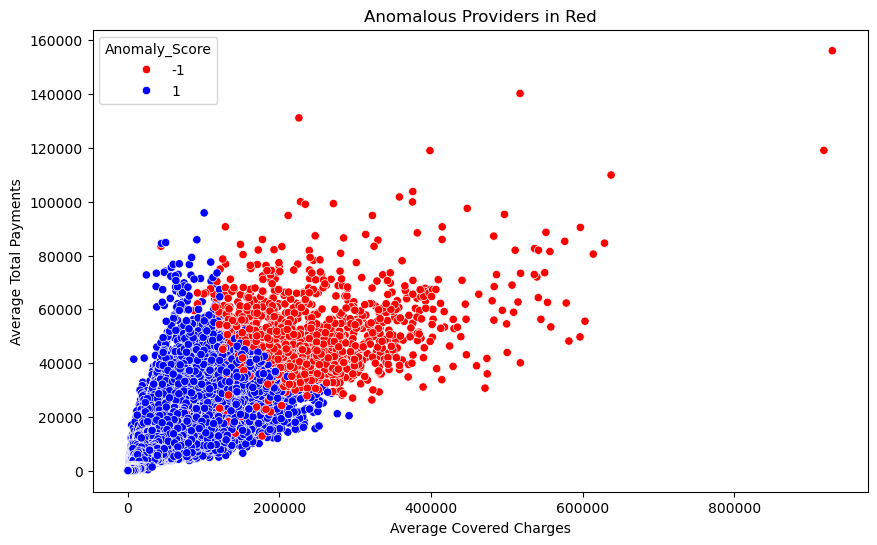

In [201]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=df['Avg_covered_charges'], 
    y=df['Average_Total_Payments'], 
    hue=df['Anomaly_Score'], 
    palette={1: 'blue', -1: 'red'}
)
plt.xlabel("Average Covered Charges")
plt.ylabel("Average Total Payments")
plt.title("Anomalous Providers in Red")
plt.show()


# Save Model

In [ ]:
with open("isolation_forest_model.pkl","wb") as file:
    pickle.dump(best_model,file)

with open("encoded.pkl","wb") as file:
    pickle.dump(encoders,file)

with open("mappings.pkl", "wb") as file:
    pickle.dump(mappings, file)

print("✅ Model Saved Successfully as isolation_forest_model.pkl")

✅ Model Saved Successfully as isolation_forest_model.pkl
